In [8]:
%load_ext autoreload
%autoreload 3

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import networkx as nx
import scipy
import sklearn
import time
import pickle
import warnings

import gconcorde as cce
from gconcorde import GraphicalConcorde, GraphicalConcordeCV
from utils import standardize, partial_corr, compute_tp_fp, mcc, precision_recall, sensitivity_specificity, BIC, pseudo_BIC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# erdos-renyi

p = 1000
n_prop_to_p = [2]
N = 1 # number of datasets
edge_prob = 0.01 # [0.03, 0.15]
random_state = 2023
lower_weight, upper_weight = 0.5, 1.0
spread_diag=[1, np.sqrt(3)]
G = nx.generators.random_graphs.erdos_renyi_graph(n=p, p=edge_prob, seed=random_state)
Skel = nx.to_numpy_matrix(G)

# Peng's method (ensuring positive definiteness of precision matrix)
np.random.seed(random_state)
edge_weights = np.random.uniform(low=lower_weight, high=upper_weight, size=(p,p))
edge_signs = np.random.choice([-1,1], size=(p,p))
Omega = np.multiply(edge_weights, edge_signs)
Omega = np.multiply(Skel, Omega)
Omega = np.tril(Omega) + np.tril(Omega).T
np.fill_diagonal(Omega, 1.5*np.abs(Omega).sum(1))
diag_inv = np.diag(1/np.sqrt(np.diag(Omega)))
Omega = diag_inv @ Omega @ diag_inv

# spread diagonal of precision matrix
d = np.random.uniform(spread_diag[0], spread_diag[1], p)
Omega = np.diag(d) @ Omega @ np.diag(d)
Partial_corr = partial_corr(Omega)
Sigma = np.linalg.inv(Omega)

# generate Gaussian data
Xs = []
for this in n_prop_to_p:
    n = int(this*p)
    for j in range(N):
        rs = np.random.RandomState(random_state)
        X = rs.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)
        X_std = standardize(X, bias=False)
        Xs.append(X)
        random_state += 1

In [12]:
# search for lambda
S = np.matmul(Xs[0].T, Xs[0], dtype=np.float64)/n
S.flat[::S.shape[0] + 1] = 0
lam_max = np.max(np.abs(S))
lam_min = 0.1 * lam_max
lams = np.logspace(np.log10(lam_min), np.log10(lam_max), 10)
lams

array([0.01995243, 0.02576955, 0.03328265, 0.0429862 , 0.05551881,
       0.0717053 , 0.09261095, 0.11961165, 0.15448438, 0.19952425])

In [13]:
for lam in lams[::-1][4:7]:
    model = GraphicalConcorde(lam1=lam, lam2=0, epstol=1e-7, maxitr=500, penalize_diag=True)
    model.fit(X)
    Omega_hat = model.precision_.toarray()
    tp, fp = compute_tp_fp(Omega, Omega_hat)
    prec, recall = precision_recall(Omega, Omega_hat)
    sens, spec = sensitivity_specificity(Omega, Omega_hat)
    print('lam:', np.round(lam, 4), ', # of nonzero:', len(np.flatnonzero(Omega_hat)), ', TP:', tp, ', FP:', fp,\
           ', MCC:', np.round(mcc(Omega, Omega_hat),3),\
           'Precision:', np.round(prec,3),\
           'Recall:', np.round(recall,3))

lam: 0.0717 , # of nonzero: 3314 , TP: 2118 , FP: 196 , MCC: 0.443 Precision: 0.915 Recall: 0.216
lam: 0.0555 , # of nonzero: 8632 , TP: 4444 , FP: 3188 , MCC: 0.51 Precision: 0.582 Recall: 0.454
lam: 0.043 , # of nonzero: 27626 , TP: 6482 , FP: 20144 , MCC: 0.392 Precision: 0.243 Recall: 0.662


In [15]:
# lam1s = lams
lam1s = lams[::-1][4:7][::-1]
lam2s = np.linspace(0, 2, 20)

precs, recalls = [], []
biased_BICs = []
biased_norms = []
debiased_BICs = np.zeros((len(lam1s), len(lam2s)))
debiased_norms = np.zeros((len(lam1s), len(lam2s)))

i = 0
for lam1 in lam1s:
    print('current lam1:', lam1)
    model = GraphicalConcorde(lam1=lam1, lam2=0, epstol=1e-7, maxitr=500, penalize_diag=True)
    model.fit(X)
    Omega_hat = model.precision_.toarray()
    Partial_corr_hat = partial_corr(Omega_hat)

    prec, recall = precision_recall(Omega, Omega_hat)
    precs.append(prec)
    recalls.append(recall)

    biased_BICs.append(pseudo_BIC(X, Omega_hat, modified=False, gamma=0.1))
    biased_norms.append(np.linalg.norm(Partial_corr - Partial_corr_hat))

    lam_mat = np.where(Omega_hat != 0, 0, 1000.0)
    j = 0
    for lam2 in lam2s:
        model = GraphicalConcorde(lam1=lam_mat, lam2=lam2, epstol=1e-7, maxitr=500, penalize_diag=True)
        model.fit(X)
        Omega_hat_debiased = model.precision_.toarray()
        Partial_corr_hat_debiased = partial_corr(Omega_hat_debiased)

        debiased_BICs[i,j] = pseudo_BIC(X, Omega_hat_debiased, modified=False, gamma=0.1)
        debiased_norms[i,j] = np.linalg.norm(Partial_corr - Partial_corr_hat_debiased)
        
        j += 1
    
    i += 1

current lam1: 0.042986197429304436
current lam1: 0.05551880889008182
current lam1: 0.07170529902401053


## p = 1000, n = 500

In [6]:
# plt.figure(figsize=(12, 8))
# s = sns.heatmap(debiased_BICs, xticklabels=np.round(lam2s,2), yticklabels=np.round(lam1s,2))

# s.tick_params(labelsize=15)
# s.set_title('Heatmap of BICs', fontsize=20)
# s.set_xlabel('$\lambda_2$', fontsize=20)
# s.set_ylabel('$\lambda_1$', fontsize=20);

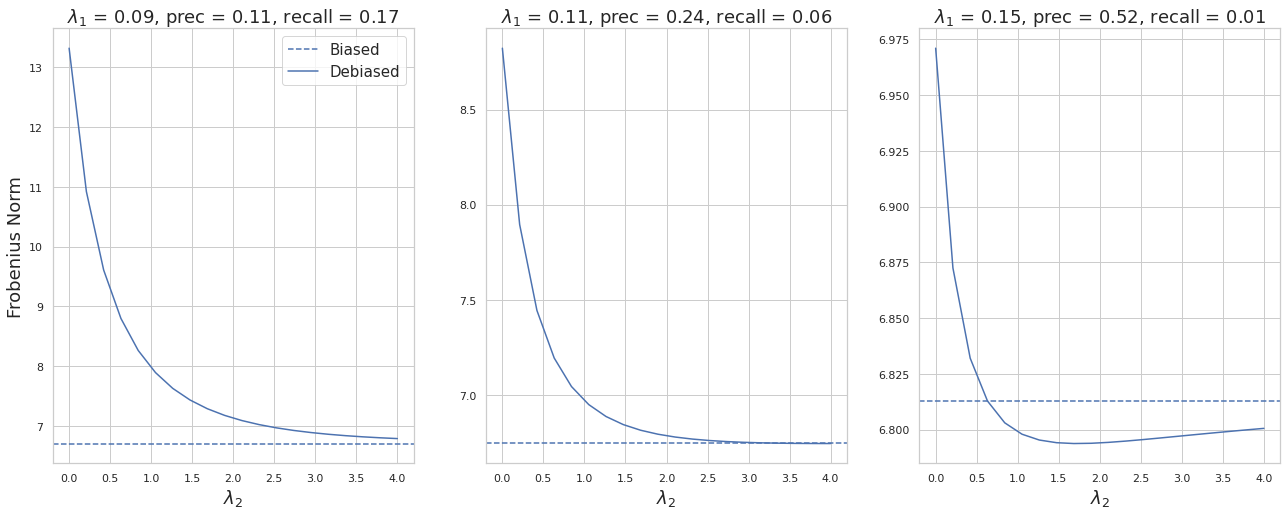

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(22, 8))
axes = axes.ravel()

i = 0
j = 0
axes[i].axhline(y=biased_norms[j], linestyle='--', color='C0', label='Biased')
axes[i].plot(lam2s, debiased_norms[j], color='C0', label='Debiased')
axes[i].set_title('$\lambda_1$ = ' + str(np.round(lam1s[j], 2)) + ', prec = ' + str(np.round(precs[j], 2)) + ', recall = ' + str(np.round(recalls[j], 2)), fontsize=18)
axes[i].set_xlabel('$\lambda_2$', fontsize=18)
axes[i].set_ylabel('Frobenius Norm', fontsize=18)
axes[i].legend(fontsize=15)

i = 1
j = 1
axes[i].axhline(y=biased_norms[j], linestyle='--', color='C0', label='Biased')
axes[i].plot(lam2s, debiased_norms[j], color='C0', label='Debiased')
axes[i].set_title('$\lambda_1$ = ' + str(np.round(lam1s[j], 2)) + ', prec = ' + str(np.round(precs[j], 2)) + ', recall = ' + str(np.round(recalls[j], 2)), fontsize=18)
axes[i].set_xlabel('$\lambda_2$', fontsize=18)

i = 2
j = 2
axes[i].axhline(y=biased_norms[j], linestyle='--', color='C0', label='Biased')
axes[i].plot(lam2s, debiased_norms[j], color='C0', label='Debiased')
axes[i].set_title('$\lambda_1$ = ' + str(np.round(lam1s[j], 2)) + ', prec = ' + str(np.round(precs[j], 2)) + ', recall = ' + str(np.round(recalls[j], 2)), fontsize=18)
axes[i].set_xlabel('$\lambda_2$', fontsize=18);

## p = 1000, n = 2000

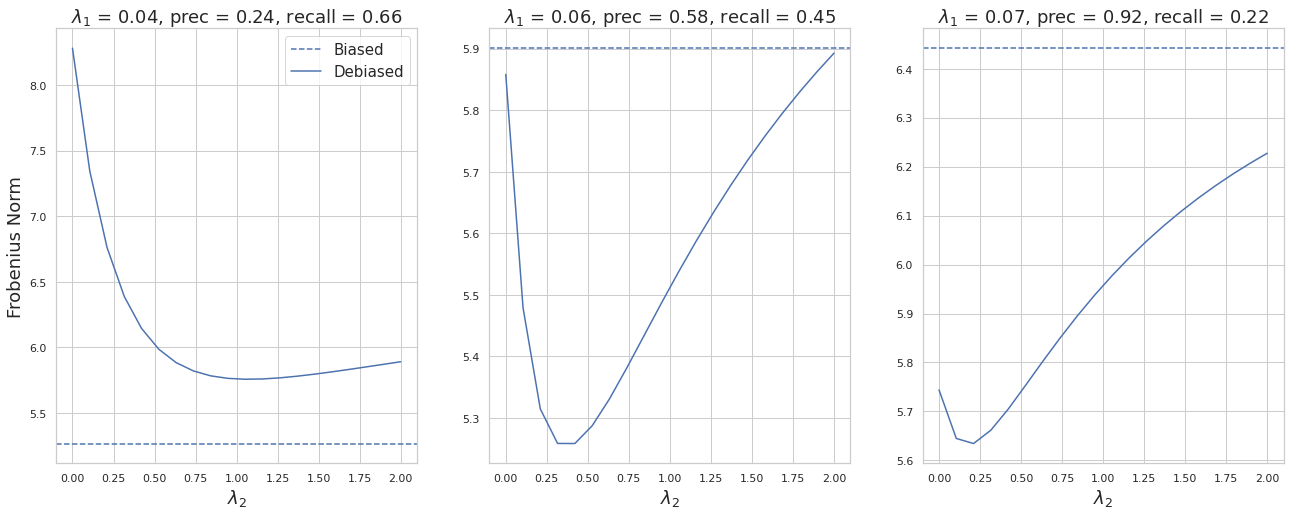

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(22, 8))
axes = axes.ravel()

i = 0
j = 0
axes[i].axhline(y=biased_norms[j], linestyle='--', color='C0', label='Biased')
axes[i].plot(lam2s, debiased_norms[j], color='C0', label='Debiased')
axes[i].set_title('$\lambda_1$ = ' + str(np.round(lam1s[j], 2)) + ', prec = ' + str(np.round(precs[j], 2)) + ', recall = ' + str(np.round(recalls[j], 2)), fontsize=18)
axes[i].set_xlabel('$\lambda_2$', fontsize=18)
axes[i].set_ylabel('Frobenius Norm', fontsize=18)
axes[i].legend(fontsize=15)

i = 1
j = 1
axes[i].axhline(y=biased_norms[j], linestyle='--', color='C0', label='Biased')
axes[i].plot(lam2s, debiased_norms[j], color='C0', label='Debiased')
axes[i].set_title('$\lambda_1$ = ' + str(np.round(lam1s[j], 2)) + ', prec = ' + str(np.round(precs[j], 2)) + ', recall = ' + str(np.round(recalls[j], 2)), fontsize=18)
axes[i].set_xlabel('$\lambda_2$', fontsize=18)

i = 2
j = 2
axes[i].axhline(y=biased_norms[j], linestyle='--', color='C0', label='Biased')
axes[i].plot(lam2s, debiased_norms[j], color='C0', label='Debiased')
axes[i].set_title('$\lambda_1$ = ' + str(np.round(lam1s[j], 2)) + ', prec = ' + str(np.round(precs[j], 2)) + ', recall = ' + str(np.round(recalls[j], 2)), fontsize=18)
axes[i].set_xlabel('$\lambda_2$', fontsize=18);